In [9]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)





Attaching package: 'WGCNA'


The following object is masked from 'package:IRanges':

    cor


The following object is masked from 'package:S4Vectors':

    cor


The following object is masked from 'package:stats':

    cor




In [10]:
source('../00_preprocessing/preprocessing.R')

In [11]:
obj = qs::qread('../01_milo/_targets/objects/obj_Day5.Astrocytes')

In [12]:
obj

An object of class Seurat 
51784 features across 5158 samples within 3 assays 
Active assay: SCT (19463 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [13]:
obj <- SetupForWGCNA(
  obj,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "Astrocytes" # the name of the hdWGCNA experiment
)

In [14]:
5000/25

[1] 200

In [15]:
# construct metacells  in each group
obj <- MetacellsByGroups(target_metacells = 200,
  seurat_obj = obj,
  group.by = c("labels", "hash.mcl.ID"), # specify the columns in seurat_obj@meta.data to group by
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'labels', # set the Idents of the metacell seurat object
  min_cells = 25,
  assay = "SCT",
  slot="counts",
  mode="sum",
  verbose=TRUE,

)

Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 4.26467331118494
Median shared cells bin-bin: 4

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 3.58674658674659
Median shared cells bin-bin: 3

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 3.16213511259383
Median shared cells bin-bin: 3

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean sha

In [16]:
# normalize metacell expression matrix:
obj <- NormalizeMetacells(obj)
obj <- ScaleMetacells(obj, features=VariableFeatures(obj))
obj <- RunPCAMetacells(obj, features=VariableFeatures(obj))
obj <- RunHarmonyMetacells(obj, group.by.vars="hash.mcl.ID")
obj <- RunUMAPMetacells(obj, reduction='harmony', dims=1:15)

Centering and scaling data matrix

PC_ 1 
Positive:  Nrxn1, Cadm2, Npas3, Mgat4c, Grm3, Erbb4, Dgkb, Qk, Fut8, Nlgn1 
	   Negr1, Ncam2, Exoc4, Slc6a11, Adgrb3, Grin2b, Kcnd2, Slc4a4, Shc3, Nckap5 
	   Pde4d, Fgf14, Sox6, Pde4b, Lsamp, Maml2, Ptprt, Adcy8, Rgs20, Fat3 
Negative:  Neat1, Iqck, Fkbp5, Slc24a4, A330033J07Rik, Spon1, Nox3, Adap2, Npas2, Acat2 
	   Zfhx3, Wnk2, ENSMUSG00000097930, Acss3, 4931429P17Rik, Pdgfd, Nxn, Kcnq3, Nat8f3, Itpr1 
	   Arhgef28, Asic2, Itih5, Plce1, Prkca, Alms1, Hr, Slc1a5, Rbms1, Megf9 
PC_ 2 
Positive:  Galnt16, Gpc5, ENSMUSG00000116763, Wwc1, Tenm4, Pcdh7, Sgip1, Ncan, Zswim5, Auts2 
	   Cyp51, Stox2, Lhfpl2, Plpp3, Eml5, Itga6, Acly, Nsdhl, Pfkfb3, Mgat5 
	   Nav2, Msmo1, Gpr158, Zeb1, Acss2, Slc13a3, Tenm3, Acvr1, Ttll8, Ank2 
Negative:  Sorbs1, Gphn, Pnpla7, Lama2, ENSMUSG00000074404, Zfhx3, Vit, Nrg2, Magi2, Fbln5 
	   Adk, Rmst, Folh1, F5, Dab1, Cdh19, Nrxn3, Gabrb1, 9530026P05Rik, Ralgps2 
	   Sox6, Fam184a, Mdga2, Lsamp, Fat3, Ccnd3, Agmo, Zc3

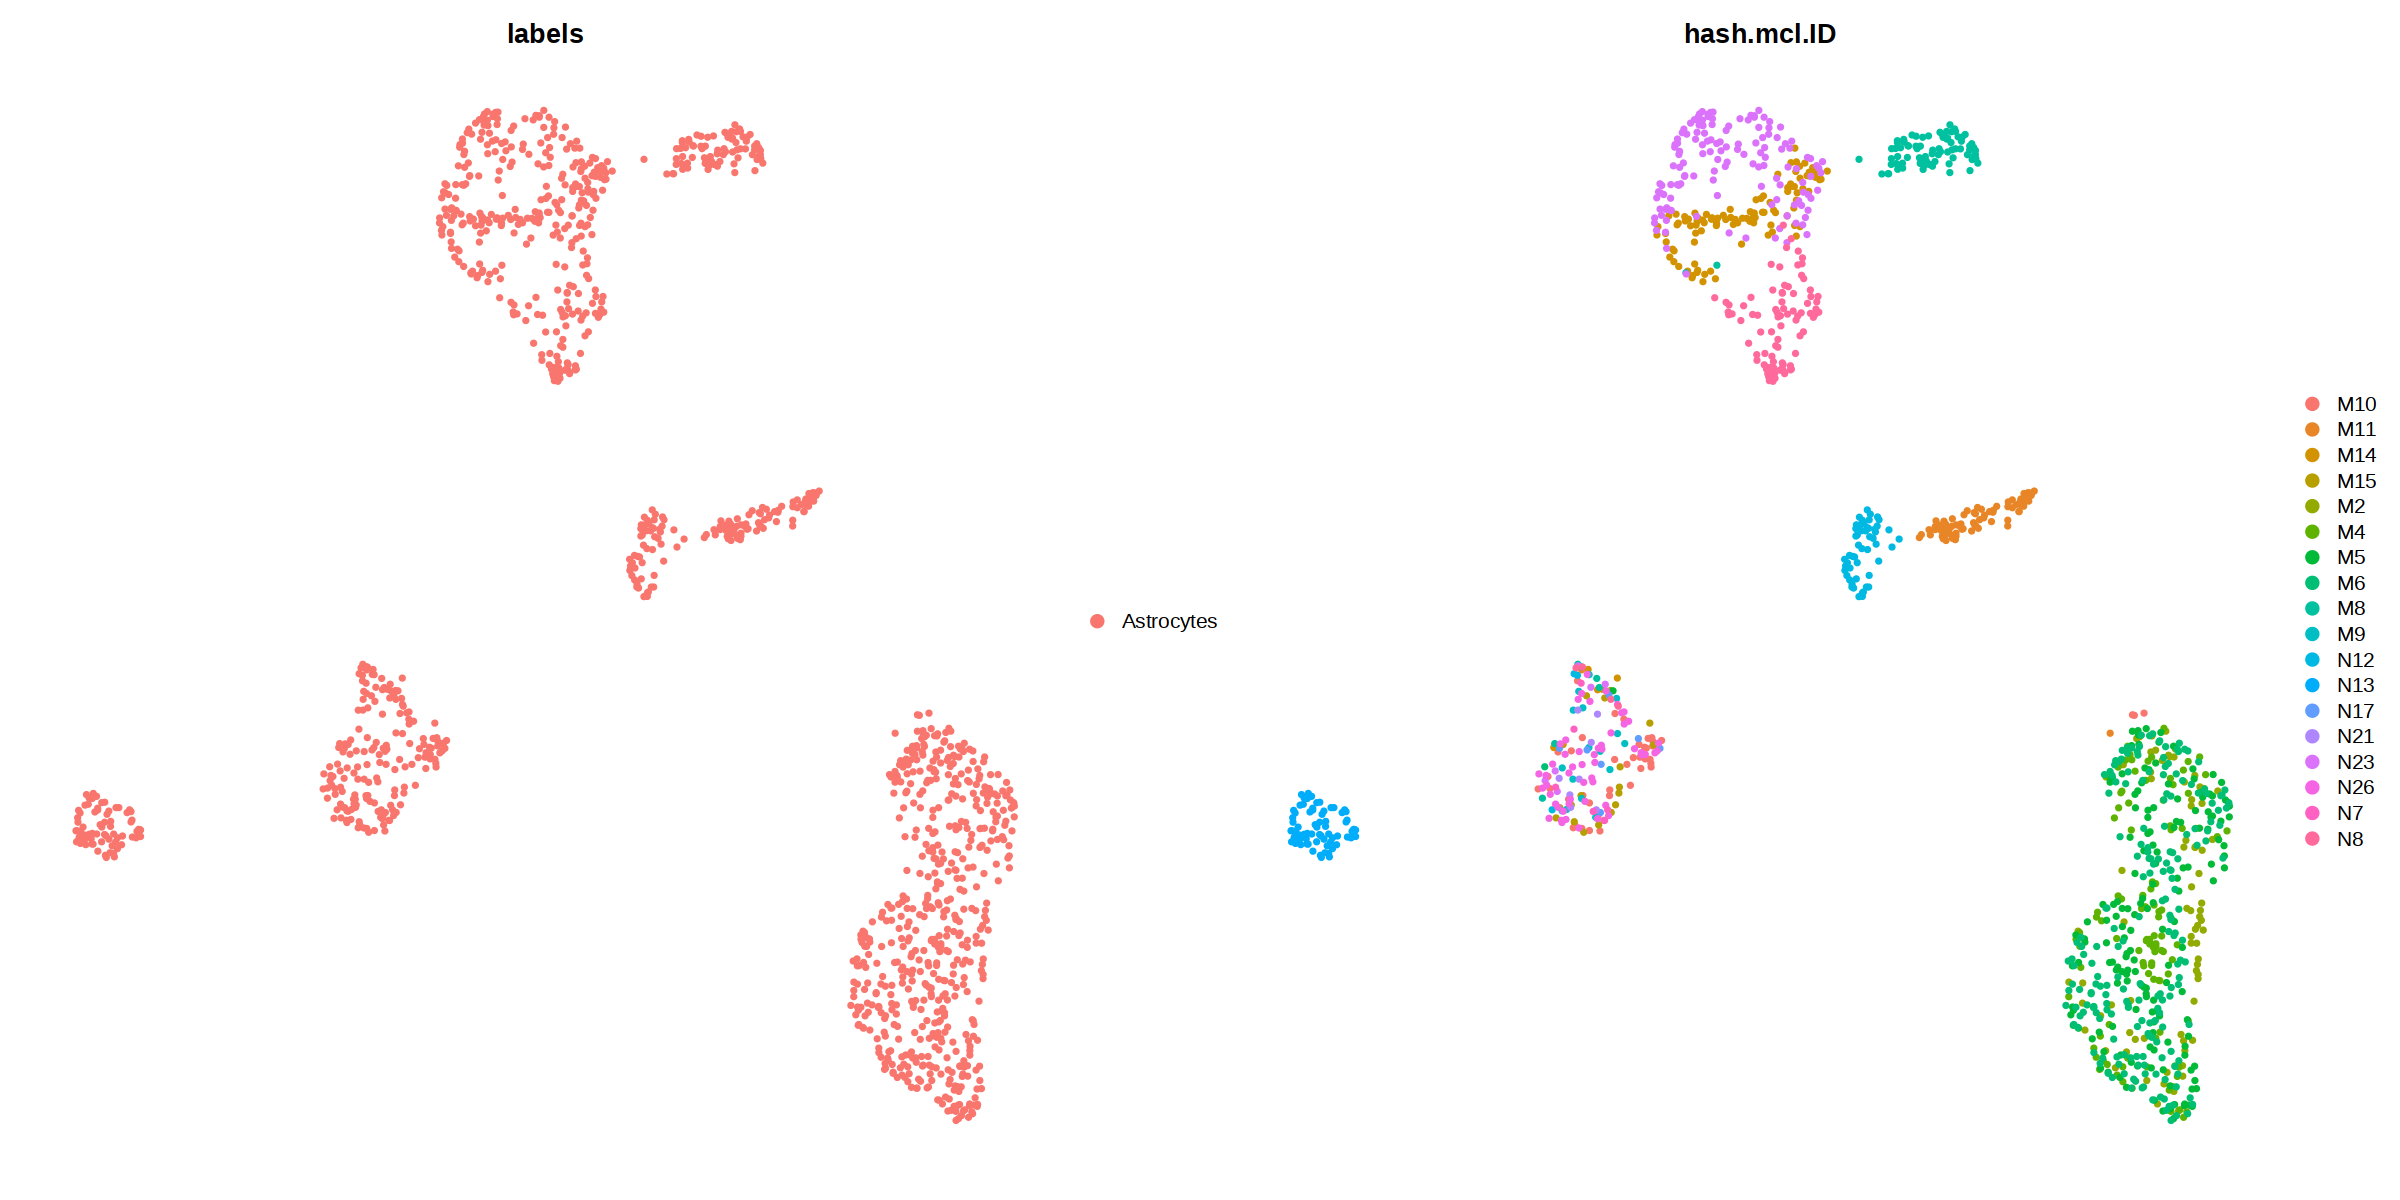

In [17]:
options(repr.plot.width=20, repr.plot.height=10)
p1 <- DimPlotMetacells(obj, group.by='labels') + umap_theme() + ggtitle("labels")
p2 <- DimPlotMetacells(obj, group.by="hash.mcl.ID") + umap_theme() + ggtitle("hash.mcl.ID")

p1 | p2

In [18]:
obj <- SetDatExpr(
  obj,
  group_name = "Astrocytes", # the name of the group of interest in the group.by column
  group.by='labels', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'SCT', # using RNA assay
  slot = 'data' # using normalized data
)

pickSoftThreshold: will use block size 4752.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4752 of 9413


Warning message:
"executing %dopar% sequentially: no parallel backend registered"


   ..working on genes 4753 through 9413 of 9413
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1  0.24100 30.600          0.829 4.76e+03  4.76e+03 4960.000
2      2  0.16200 12.700          0.878 2.41e+03  2.42e+03 2630.000
3      3  0.04760  4.630          0.929 1.23e+03  1.23e+03 1400.000
4      4  0.00256 -0.843          0.968 6.30e+02  6.30e+02  759.000
5      5  0.05880 -3.470          0.992 3.23e+02  3.23e+02  416.000
6      6  0.25400 -6.700          0.955 1.67e+02  1.66e+02  236.000
7      7  0.49200 -8.540          0.904 8.64e+01  8.60e+01  137.000
8      8  0.67300 -8.930          0.879 4.49e+01  4.46e+01   80.900
9      9  0.81200 -8.510          0.885 2.35e+01  2.32e+01   49.100
10    10  0.90200 -7.770          0.918 1.23e+01  1.21e+01   30.500
11    12  0.96300 -6.000          0.953 3.43e+00  3.32e+00   12.800
12    14  0.56600 -6.490          0.457 9.76e-01  9.28e-01    6.160
13    16  0.96900 -3.440          0.988 2.84e-01  2.62e-01    3.430


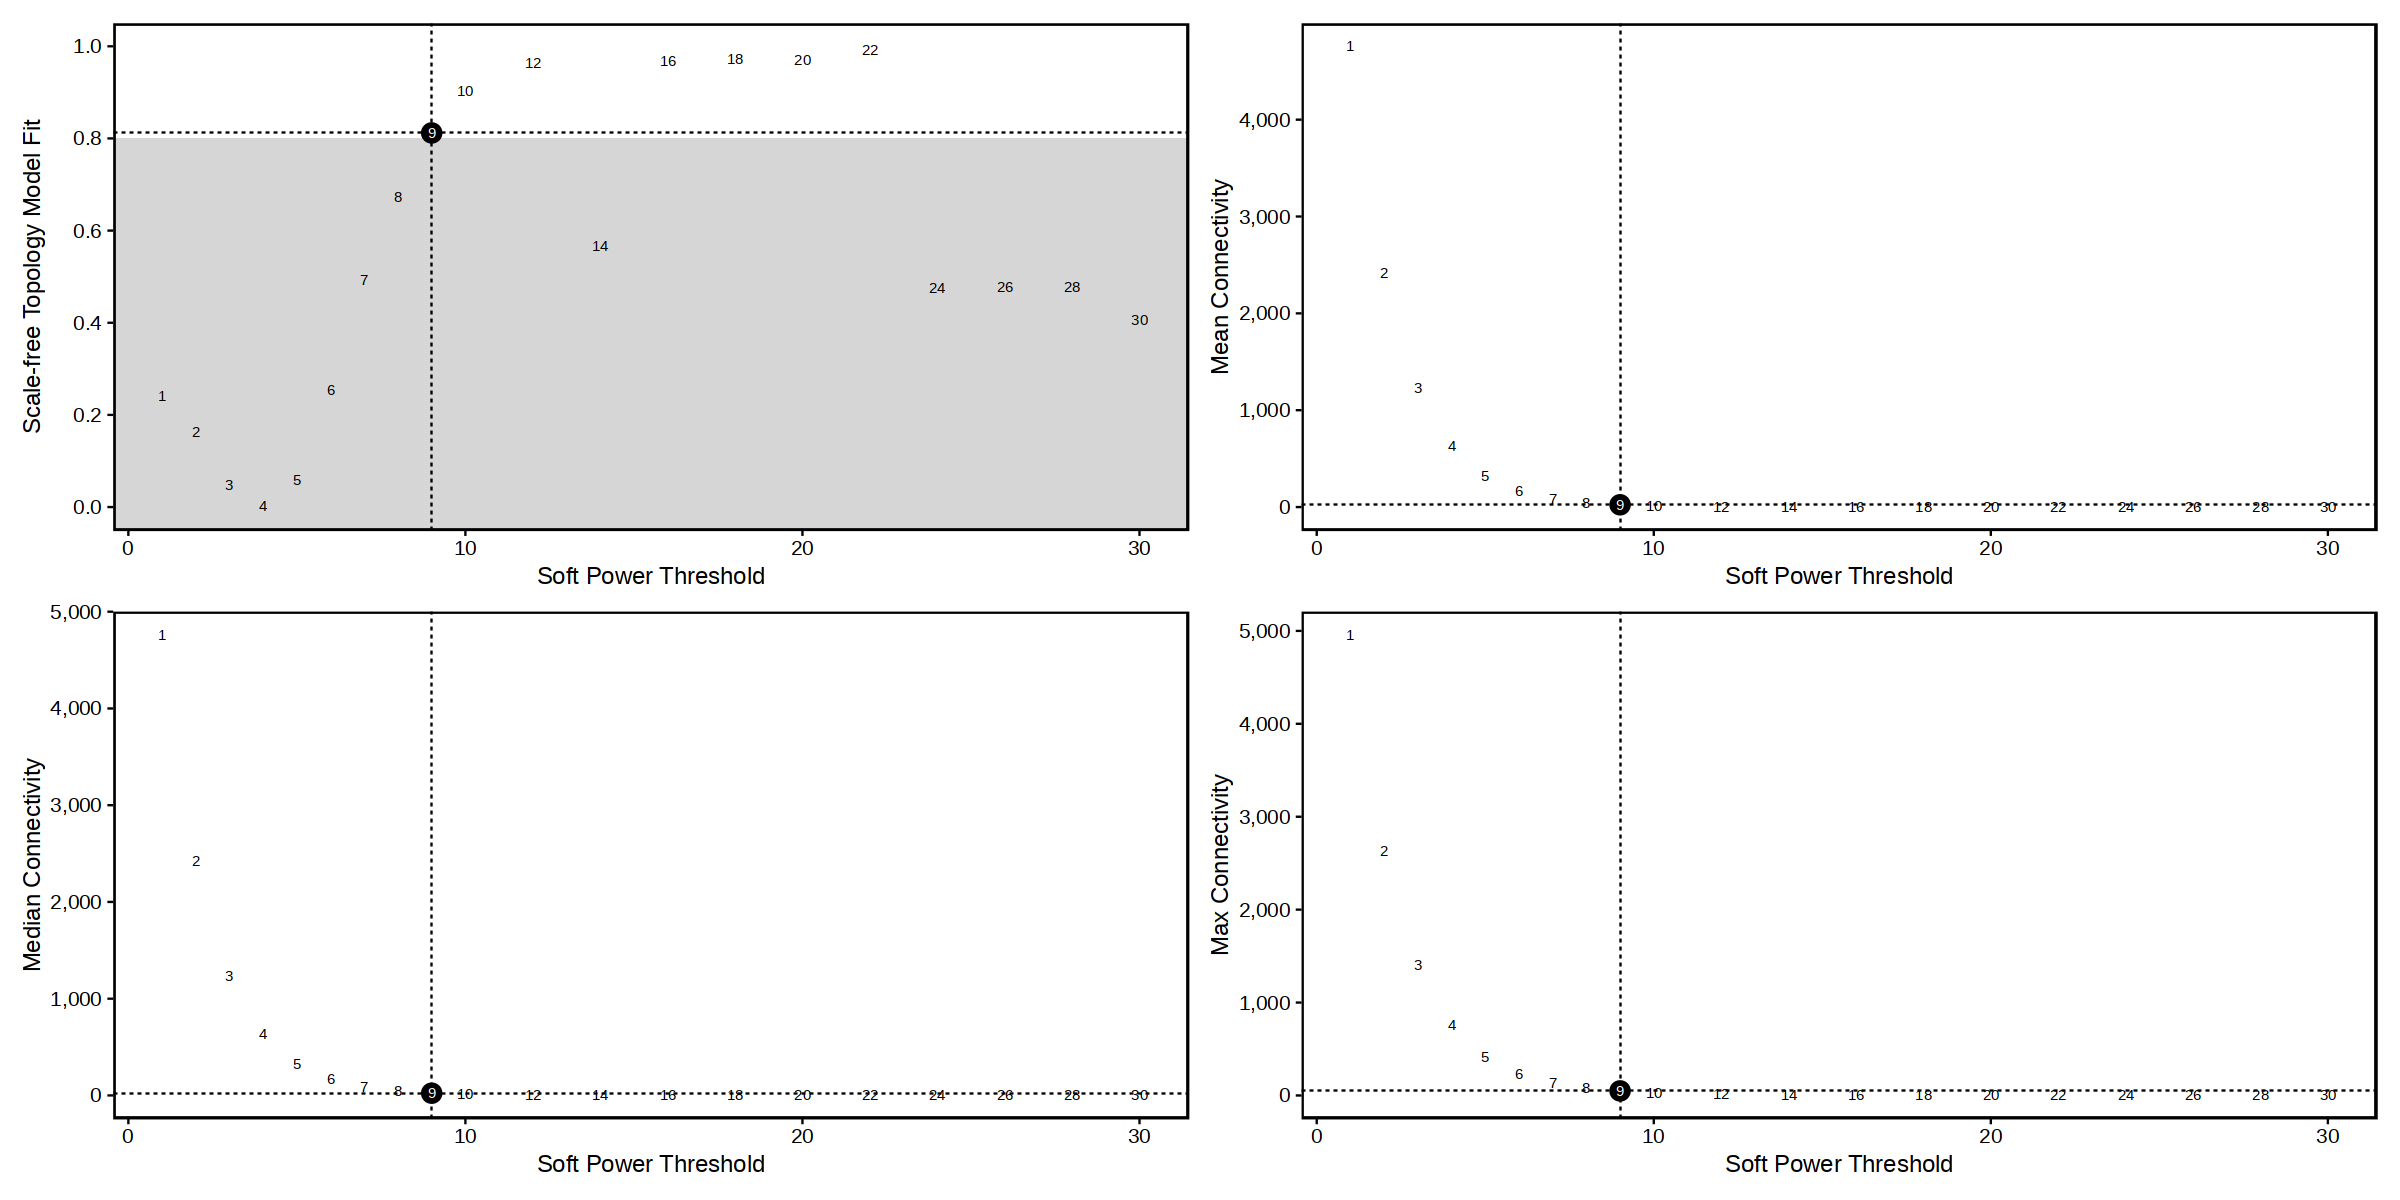

In [19]:
# Test different soft powers:
obj <- TestSoftPowers(
  obj,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [20]:
# construct co-expression network:
obj <- ConstructNetwork(
  obj,
  setDatExpr=FALSE,
  tom_name = 'Astrocytes', # name of the topoligical overlap matrix written to disk,
  overwrite_tom = TRUE
)

Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 9
 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


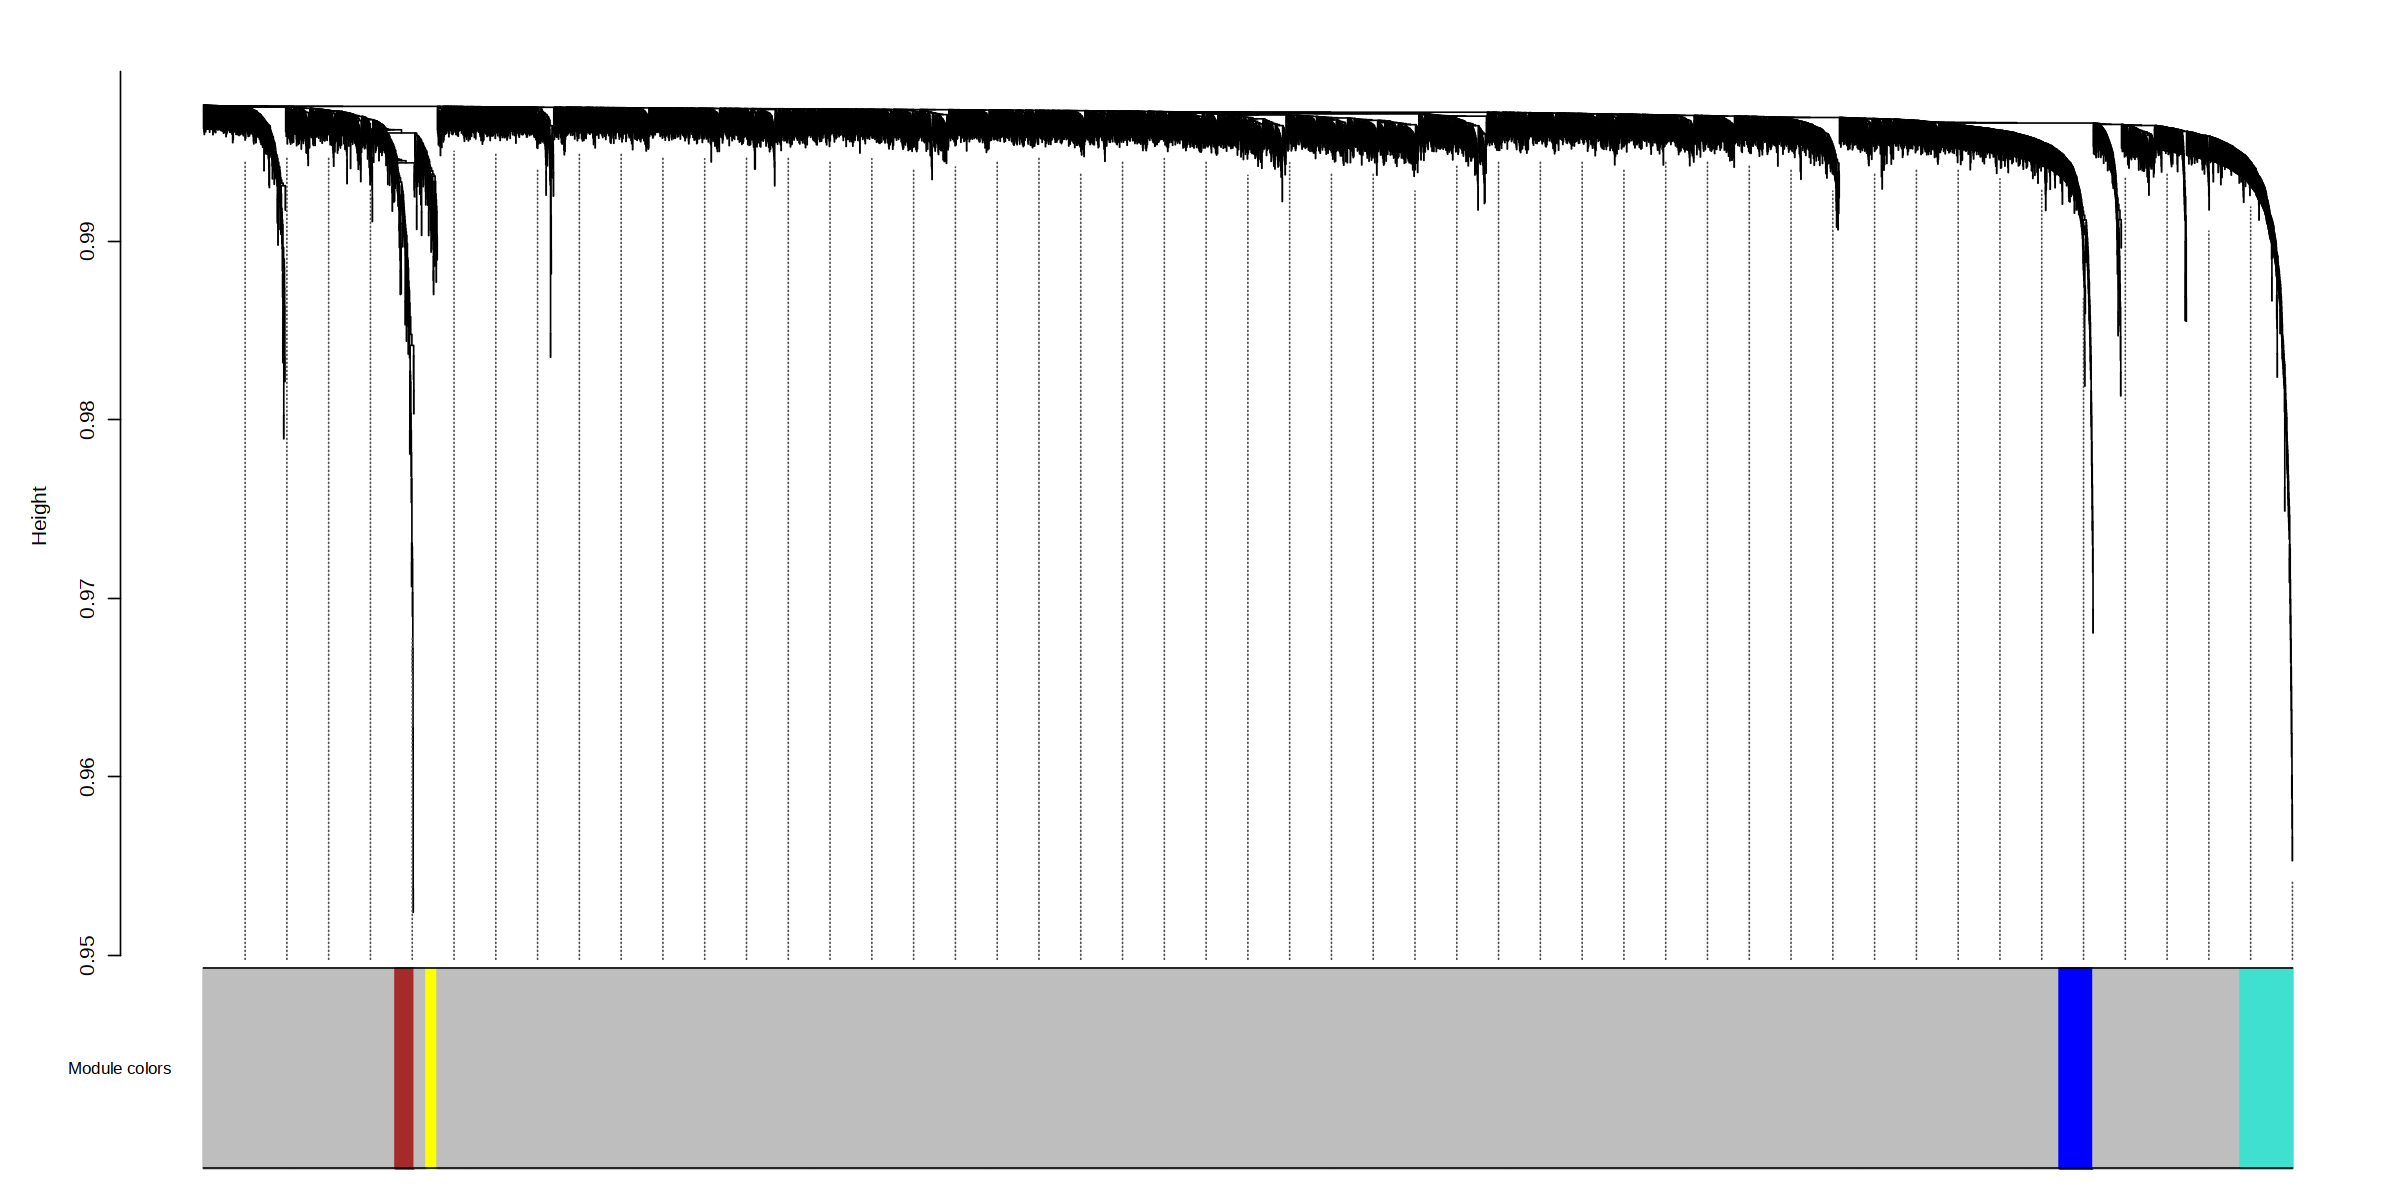

In [21]:
PlotDendrogram(obj)

In [ ]:
# need to run ScaleData first or else harmony throws an error:
plan("sequential")
obj <- ScaleData(obj, features=VariableFeatures(obj))

# compute all MEs in the full single-cell dataset
obj <- ModuleEigengenes(
 obj,
 group.by.vars="hash.mcl.ID"
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix



In [25]:
# harmonized module eigengenes:
hMEs <- GetMEs(obj)

# module eigengenes:
MEs <- GetMEs(obj, harmonized=FALSE)

In [27]:
# compute eigengene-based connectivity (kME):
obj <- ModuleConnectivity(
  obj,
  group.by = 'labels', group_name = 'Astrocytes'
)

Warning message in bicor(datExpr, datME, , use = "p"):
"bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD."


In [28]:
obj <- ResetModuleNames(
  obj,
  new_name = "Astrocytes_M"
)

[1] "Astrocytes_M1"
[1] "Astrocytes_M2"
[1] "Astrocytes_M3"
[1] "Astrocytes_M4"
[1] "Astrocytes_M1"
[1] "Astrocytes_M2"
[1] "Astrocytes_M3"
[1] "Astrocytes_M4"


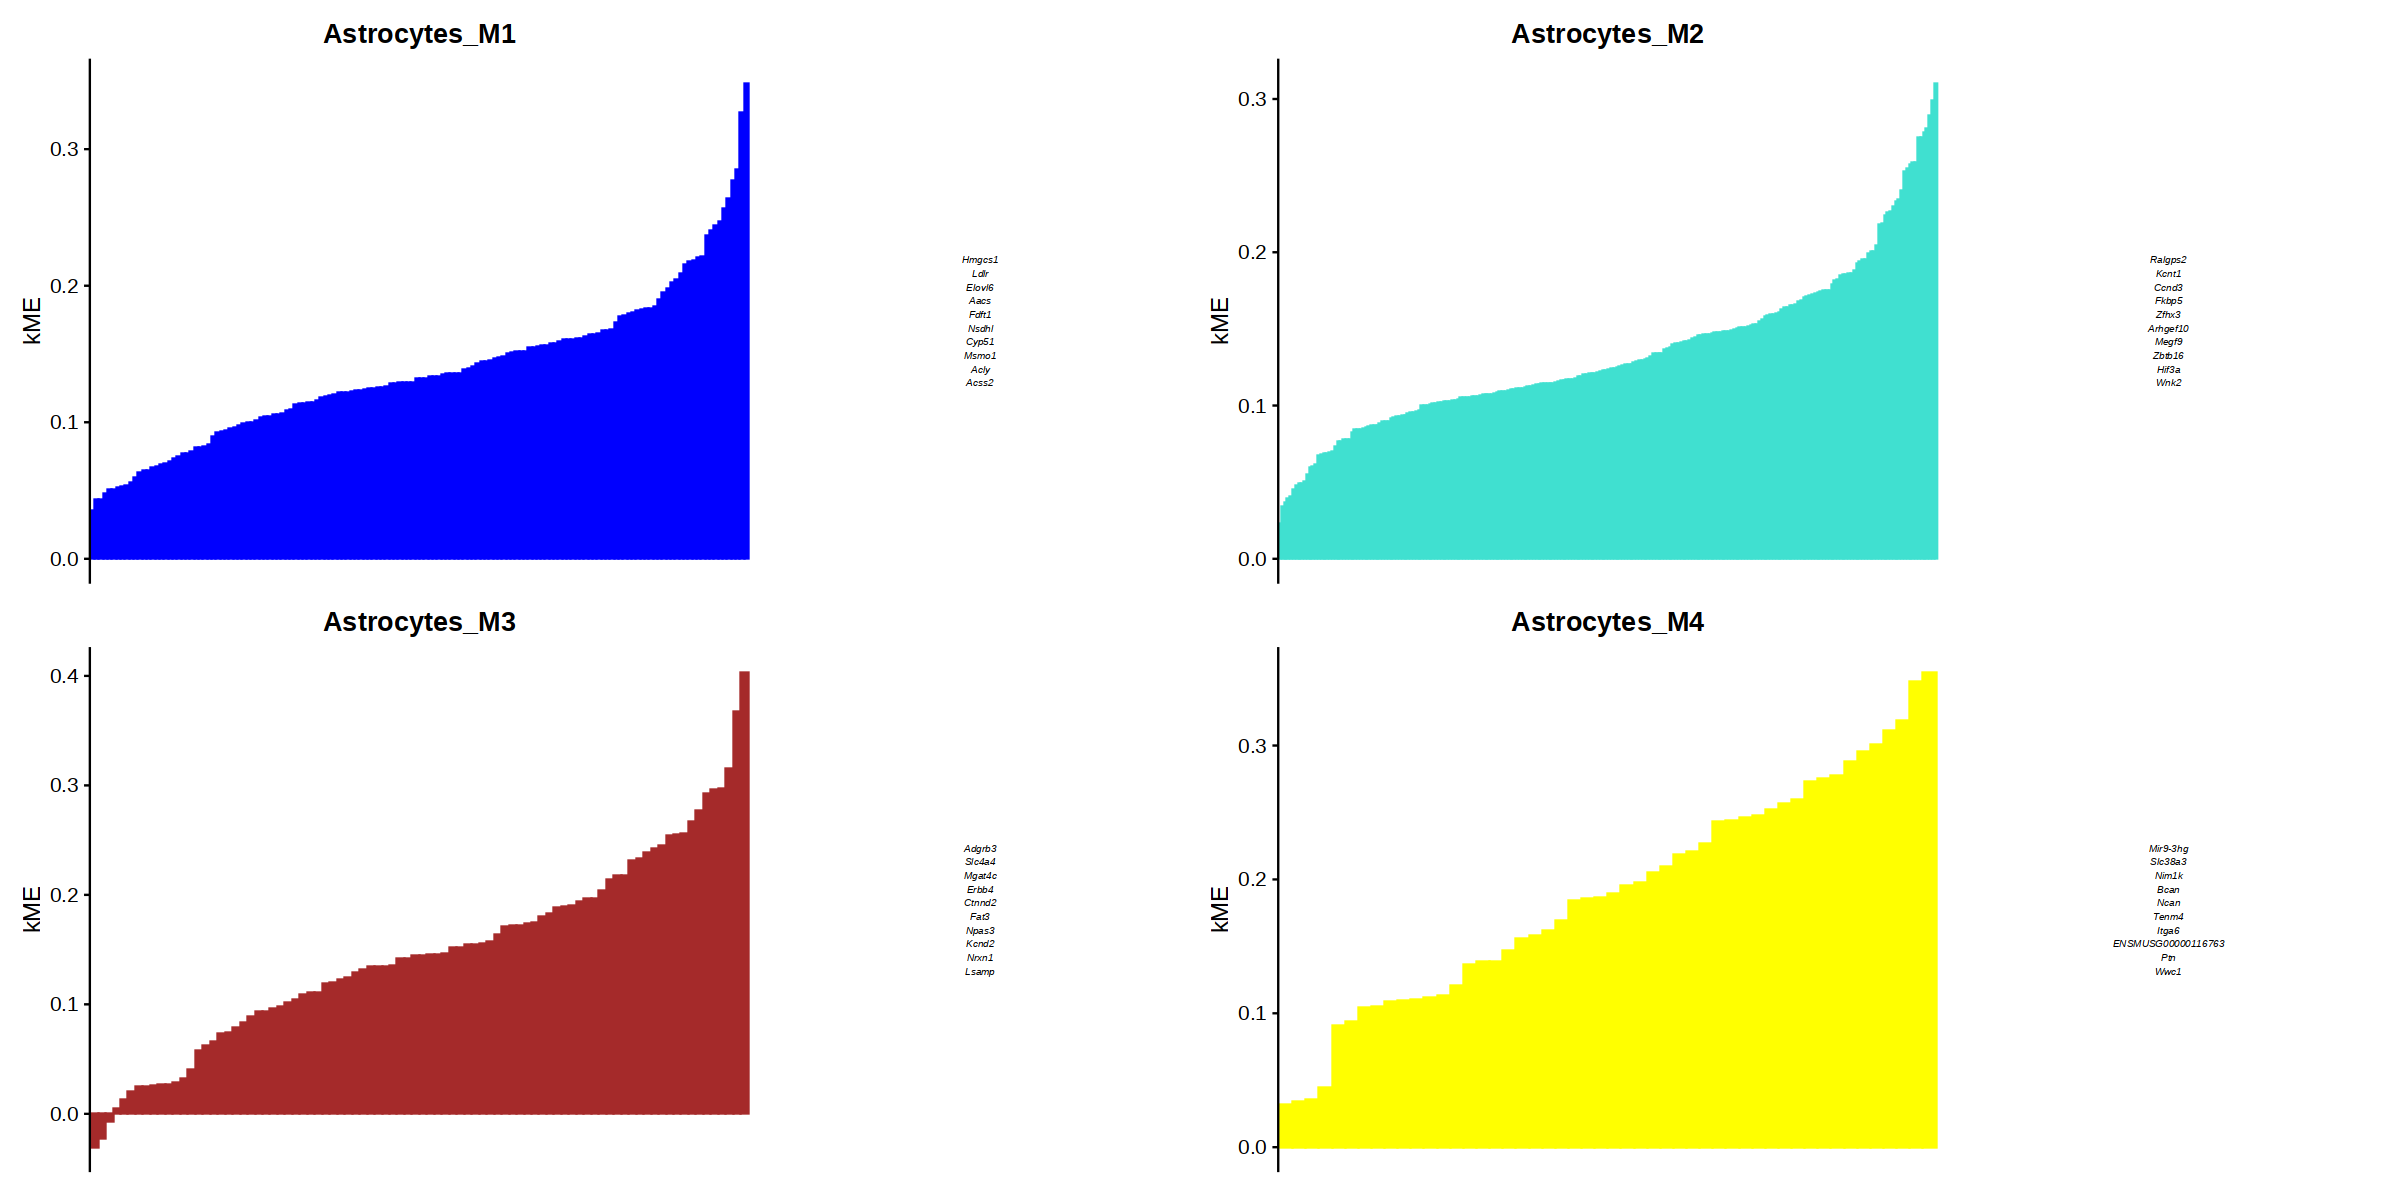

In [29]:
options(repr.plot.width=20, repr.plot.height=10)
p <- PlotKMEs(obj, ncol=2)
p